# Clustering and data visualisation
A common objective of biological data science is data exploration. Exploring data is useful if sample labels are unavailable or if we wish to assess data for confounding batch effects which are unrelated to biology. The sklearn library provides several tools for such unsupervised analysis. As representative of clustering, we will first apply the k-means approach. Besides selecting a method, the most important decision in clustering is specifying an appropriate number of clusters. We may to this end use metrics like the silhouette_score or the calinski_harabasz_score which are provided in sklearn.metrics to compare clusterings of data obtained with different cluster numbers. While these metrics provide additional guidance, model complexity metrics like AIC or BIC have an interpretation in terms of Occams razor. Giving rise to a proper model likelihood is a prerequisite for allowing to calculate such complexity metrics. Although k-means fails in this respect, the ml_lib propovides a score which we may regarded as a crude approximate of a log likelihood. 

## Fitting clustering methods
Methods like k-means, spectral clustering or Gaussian mixture models are highly nonlinear with many local optima. Allthough obtaining the global optimum is in general impossible, we must strive to obtain a solution which is at least reasonably similar to a global optimum. To obtain such solutions clustering methods are repeatedly started from randomly initialised parameters. The final solution is obtained iteratively, accepting a new local optimum only if its score outperforms the score of all previous runs. In particular for larger cluster numbers, we can not repeat model fitting often enough. 

## K-means with sklearn
The ml_lib.py provides a wrapper for the sklearn k-means approach which calculates the before mentioned crude approximate log likelihood in order to guide model selection by approximate AIC and BIC metrics. As we are really talking about crude approximations, we should also consider additional cluster validation methods like the silhouette_score or the calinski_harabasz_score.

## Data loading

In [1]:
## decide whether we run code in google colab amd access the google drive or 
## whether we run locally
incolab=False
if incolab:
    ## we mount the drive and set the basepath
    from google.colab import drive
    drive.mount('/content/drive')
    basepath="/content/drive/My Drive/exercise4colab.4students/"
else:
    ## we run locally and basepath is the parent directory 
    basepath="../"
### ml_lib.py resides in <basepath>/course.lib and contains course relevant
### library functions. To allw loading it we set a temporary path to
### the directory
import sys
sys.path.append(basepath+"course.lib/")
import ml_lib as mlib
## generic imports
import sklearn
import numpy as np
import pandas as pd
## We implement a classifier for selected GBM Affymetrix sample type
## specific genes. The data is quality checked, vsn transformed and ls
## normalised.
fnambase=basepath+"/course_data/GBM_AFFY_nrm_samplesel"
## set up an eset (synonymous to bioconductor esets)
gbmeset=mlib.PyEset()
## load the data using defaults (log 2 scale)
gbmeset.loadfromfile(fnambase)
## convert it to sklearn compatible data (split as input and target)
## The matrices which result from gbmeset.tolabeleddata(labelcol) match
## sklearn assumptions that rows are samples and columns are features.
labelcol="sample_type"
data4ml=gbmeset.tolabeleddata(labelcol)
y=data4ml["Y"] 
print(set(y))
## gbmeset has an item getter which allows for 
## indexing with boolean pandas series or
## vectors and lists. Since we want to cluster
## only the tumor samples, we extract those 
eset4clustering=gbmeset[:, y=="Primary Tumor"]
## Verhaak labels if known...
labelcol="verhaak.label"
data4ml=eset4clustering.tolabeleddata(labelcol)
X=data4ml["X"] 
y=data4ml["Y"] 
## X is your clustering input y provides some known GBM 
## subtypes (not all are known)

map2log
{'Solid Tissue Normal', 'Primary Tumor'}


In [2]:
import collections

collections.Counter(y)

Counter({'none': 334,
         'Classical': 31,
         'Neural': 24,
         'Proneural': 45,
         'Mesenchymal': 49})

## Using wrap_kmeans

In [3]:
from ml_lib import wrap_kmeans
from ml_lib import linmap
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
maxit=500          # iterations within a k-means fit
nrep=100           # number of repetions of k-means fitting for one k
njobs=-1           # parallelization
mink=2             # range of k
maxk=30
init='k-means++'   # parameter for sklearn k-means
# most happens inside wrap_kmeans!
res=wrap_kmeans(X, mink, maxk, nrep=nrep, njobs=njobs, init=init, maxit=maxit)

C:\Users\lilek\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\lilek\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\lilek\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\lilek\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"
C:\Users\lil

## Plot of complexity penalties

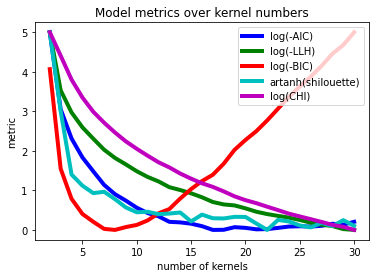

In [4]:
# plot cluster metrics
myfig=plt.figure()
plt.clf()
# all scores get transformed and mapped to the range 0-5
l1=plt.plot(res['allk'], linmap(np.log(-res['aics'])), 'b-', linewidth=4, 
            label='log(-AIC)')
l2=plt.plot(res['allk'], linmap(-res['llhs']), 'g-', linewidth=4, 
            label='log(-LLH)')
l3=plt.plot(res['allk'], linmap(np.log(-res['bics'])), 'r-', linewidth=4, 
            label='log(-BIC)')
l4=plt.plot(res['allk'], linmap(np.arctanh(res['shlts'])), 'c-', linewidth=4, 
            label='artanh(shilouette)')
l5=plt.plot(res['allk'], linmap(np.log(res['chinds'])), 'm-', linewidth=4, 
            label='log(CHI)')
plt.ylabel('metric')
plt.xlabel('number of kernels')
plt.title('Model metrics over kernel numbers')
plt.legend(loc=1)
plt.show()
with PdfPages(basepath+'resfigs/GBM_patient_clusters_aic_bic.pdf') as pdf:
    pdf.savefig(myfig)

## Interpreting cluster number metrics

The approximate BIC suggests that six clusters are optimal. This is twice the number of the GBM subtypes that were proposed by the analysis of Verhaak et al. in 2010. The above plot replicates a usual finding with AIC based model selection, namely the tendency of AIC to overestimate model complexity for large sample sizes. The difficulty of selecting an optimum is apparent from the fact that both silhouette and Calinski Harabasz scores are optiumal for 2 clusters. The Verhaak proposition of 4 GBM subtypes is thus in the range of clusters predicted by the k-means approach.

## Visualising BIC optimal clusters with a two dimensional PCA projection

Allthough PCA is in terms of number of applications a bit overrated as projection, it is numerically simple to obtain and thus our first visualisation approach. We propose to this end to apply sklearn.decomposition.PCA with 2 components to the gene expression matrix X and visualise the projected expression vectiors together with the projected k-means cluster centers.

In [5]:
## This is your turn again: provide a visualisation of the 
## gene expression data X and the BIC optimal cluster centers 
## using a PCA projection.
## the optimal BIC model is obtained as follows
bic_opt_mdl=res['bicpars'][0]
opt_centers=bic_opt_mdl.cluster_centers_
print(opt_centers.shape) ## should be (8 x 501)
## HINT: sklearn provides PCA by instantiating 
## sklearn.decomposition.PCA
from sklearn.decomposition import PCA
#perform PCA
pca=PCA(n_components=2)
X_trans = pca.fit_transform(X)
X_trans_pca = X_trans

(8, 501)


In the scoreplot below additionally 8 centers for each cluster are plotted. Most of the separation between is along PC1.

Text(0, 0.5, 'PC2')

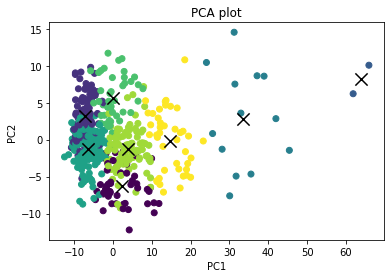

In [6]:
#visualize the results
labels = res['bicpars'][0].labels_
plt.scatter(X_trans[:,0],X_trans[:,1],c=labels)
plt.scatter(pca.transform(opt_centers)[:,0],pca.transform(opt_centers)[:,1],marker="x",s=150,c="black")
plt.title("PCA plot")
plt.xlabel("PC1")
plt.ylabel("PC2")


In [7]:
pca.transform(opt_centers)[:,0]

array([ 2.21768302e+00, -7.30119098e+00,  6.38429170e+01,  3.33826890e+01,
       -6.37551274e+00,  4.89197178e-02,  3.85962444e+00,  1.46338425e+01])

## tSNE : an advanced ML approach for visualising data

While PCA is quick, the projections are based on a simple 
coordinate rotation under the assumption that X is drawn from a 
multivariate Gaussian. In many situations improved visualisations
are obtained by advanced methods like tSNE. It should however be
kept in mind that tSNE is a nonlinear approach which converges to
local optima. Parameter estimation should thus keep track of the overall 
optimum and repeat model fitting from random initialisations.

In [8]:
## Hint: tSNE is available in sklearn as sklearn.manifold.TSNE
## Model fitting has to vary perplexity. For every perplexity 
## we should select a model with a reasonable good score by 
## iterating over as many optimisations as we can afford.
from sklearn.manifold import TSNE

## 1) we will now transform the data to a TSNE representation. The
## proposition in high dimensional situations is to project the entire
## data first to PCA space (e.g. 100 dimensions) and subsequently apply TSNE 

## 2) fit tSNE on a matrix which combines data and kernel centers simultaneously. 
## (tSNE is a non parametric approach which has no underlying model)

## 3) plot the data for different perplexities in several subplots
## For visualisation separate them afterwards and plot kernel centers and samples 
## allocated to the kernel in the same colour.

opt_centers=bic_opt_mdl.cluster_centers_
tsne = TSNE(random_state=1234) #added random_state for reproducibility # https://stackoverflow.com/questions/43321394/what-is-random-state-parameter-in-scikit-learn-tsne
X_tsne = np.concatenate((X,opt_centers),axis=0)
X_trans = tsne.fit_transform(X_tsne)
center_tsne = X_trans[-8:,:]
X_trans = X_trans[:-8,:]

In [9]:
#check if dimension of center_tsne is correct 
np.shape(center_tsne)

(8, 2)

In [10]:
#show coordinates for center_tsne
center_tsne

array([[ 3.9048905 ,  2.735521  ],
       [ 0.5587663 , -8.78797   ],
       [-6.3509517 , 14.3756485 ],
       [-5.8739    , 12.929523  ],
       [ 3.5944297 , -5.710984  ],
       [-3.022357  , -1.8811542 ],
       [-0.83974826,  4.2571487 ],
       [-4.399623  ,  9.41328   ]], dtype=float32)

Text(0.5, 1.0, 'tSNE plot')

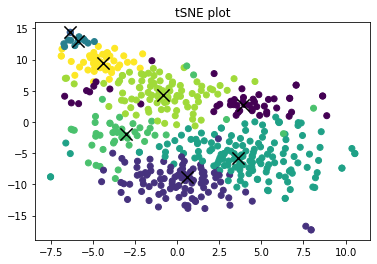

In [11]:
#visualize the results
labels = res['bicpars'][0].labels_
plt.scatter(X_trans[:,0],X_trans[:,1],c=labels)
plt.scatter(center_tsne[:,0],center_tsne[:,1],marker="x",s=150,c="black")
plt.title("tSNE plot")

## tSNE using different perplexities

Additionally different perplexities were used (`per = range(5,51,5)`) based on the suggestion from [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html). A nice explanation of the impact of different perplexities is given [here](https://scikit-learn.org/stable/auto_examples/manifold/plot_t_sne_perplexity.html). As the perplexity value increases a tendency towards clearer shapes should be seen. An nice, interactive simulation could be seen [here](https://distill.pub/2016/misread-tsne/).
With perplexitiy the user could set "how to balance attention between local and global aspects of your data". It is "a guess about the number of close neighbors each point has".
So it should be varied and chosen carefully.
The results show that there isn't an obvious trend. E.g. perplexity 5 and 20 deliver good results. The results using perplexity 10 and 15 are worse.






In [12]:
#define range of perplexities
per = range(5,51,5)
results_X_trans={}
results_center_tsne={}
#perform tsne
for i in per:
    tsne = TSNE(perplexity=i, random_state=1234)
    X_tsne = np.concatenate((X,opt_centers),axis=0)
    X_trans = tsne.fit_transform(X_tsne)
    results_center_tsne[i]=X_trans[-8:,:]
    results_X_trans[i]=X_trans[:-8,:]
    

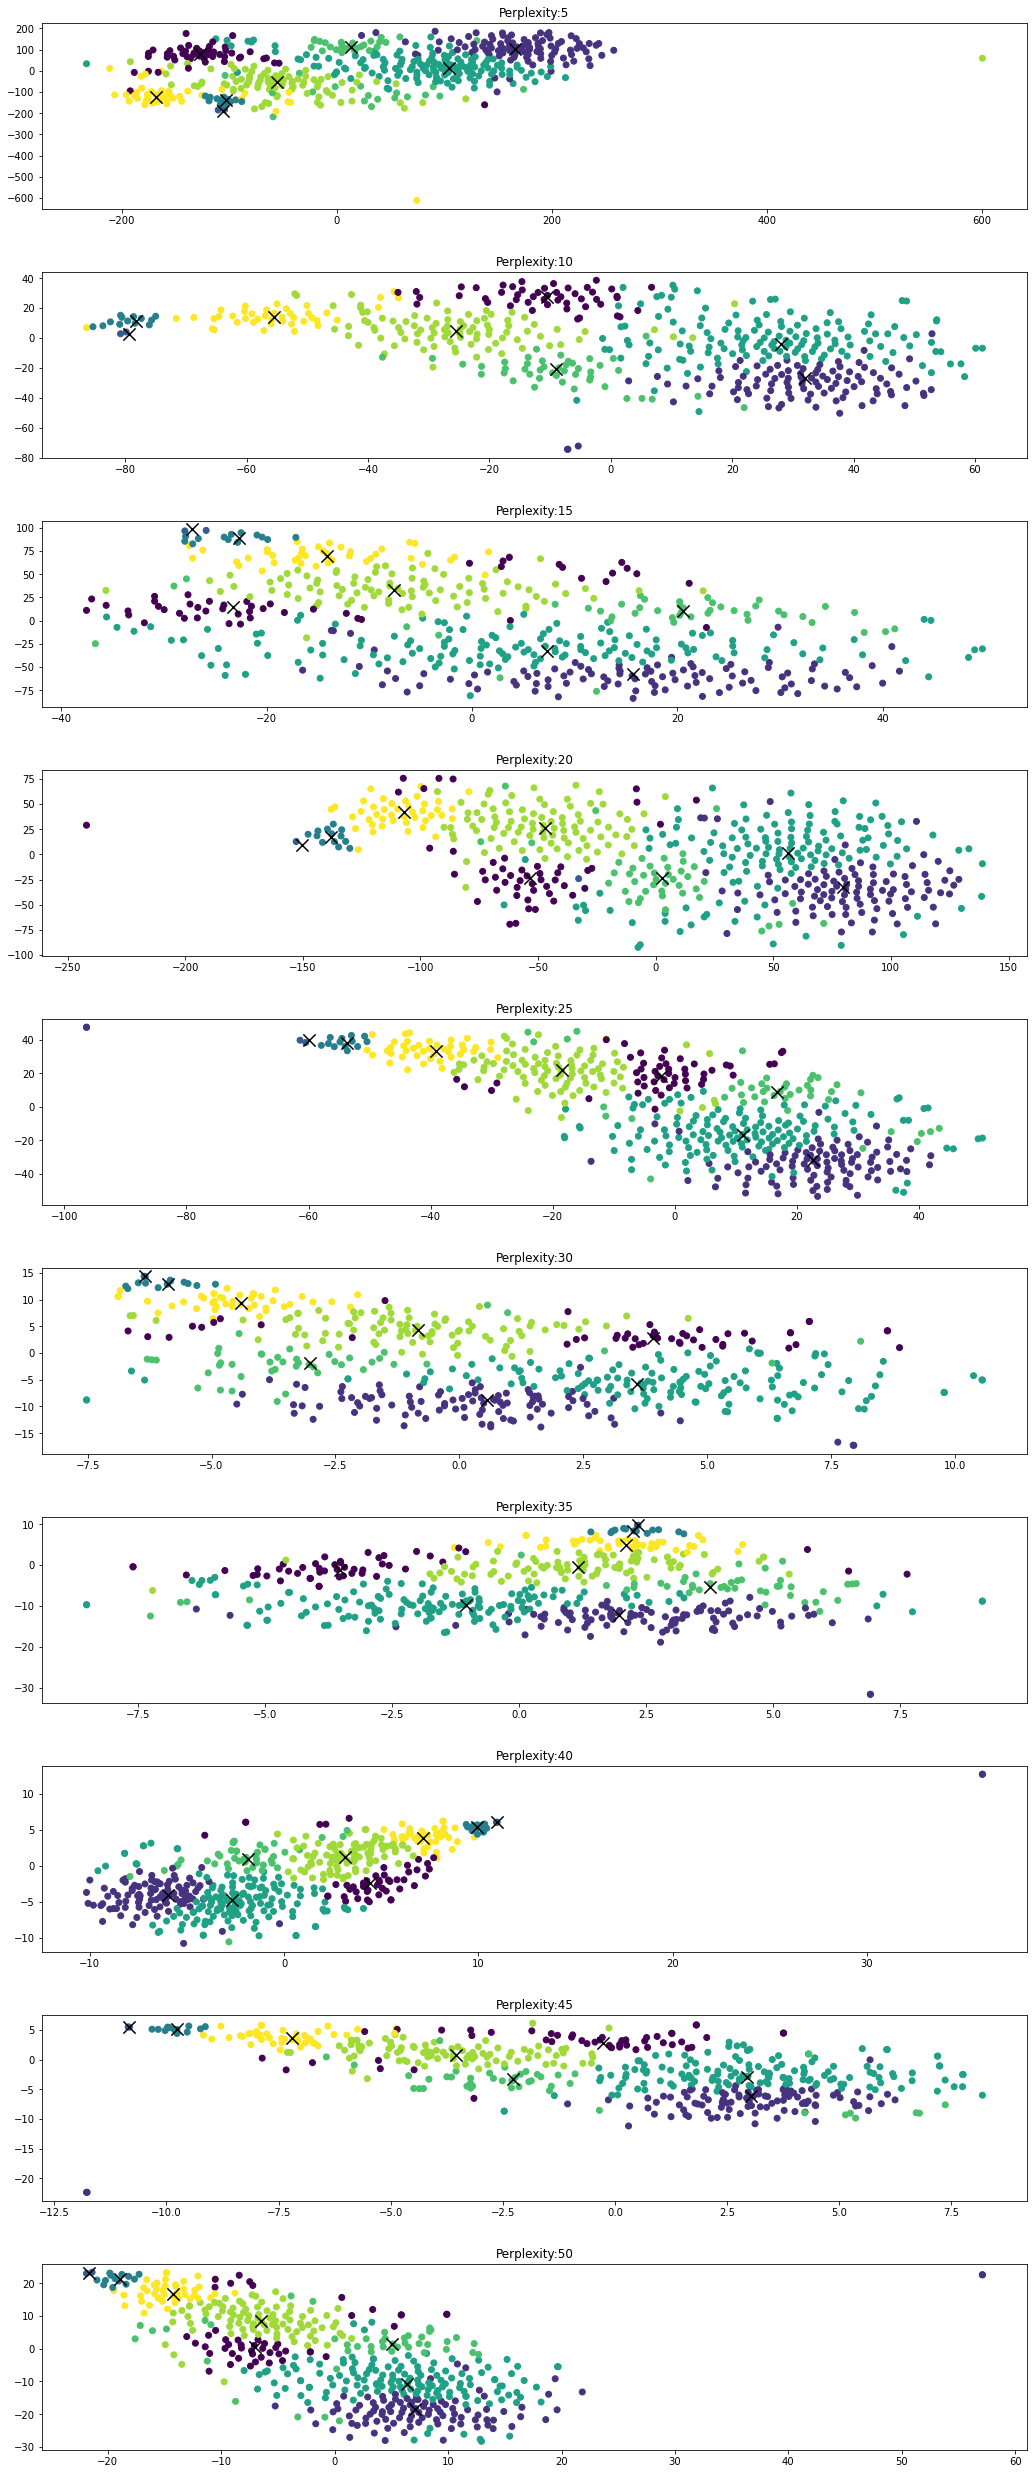

In [13]:
fig, axs = plt.subplots(10, figsize=(15,35))
for count, k in enumerate(results_X_trans):
    #visualize the results
    axs[count].labels = res['bicpars'][0].labels_
    axs[count].scatter(results_X_trans[k][:,0],results_X_trans[k][:,1],c=labels)
    axs[count].scatter(results_center_tsne[k][:,0],results_center_tsne[k][:,1],marker="x",s=150,c="black")
    axs[count].title.set_text(f"Perplexity:{k}")
    fig.tight_layout(pad=3.0) #distance between plots

## Spectral clustering
Experiment yourself with spectral clustering. Provide a quantitative assesment of similarities and differences in comparison with k-means clustering.



Some [INFO from scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html)

* In practice Spectral Clustering is very useful when the structure of the individual clusters is highly non-convex, or more generally when a measure of the center and spread of the cluster is not a suitable description of the complete cluster, such as when clusters are nested circles on the 2D plane.
* works well for a small number of clusters, but is not advised for many clusters.
* Different label assignment strategies can be used, corresponding to the assign_labels parameter of SpectralClustering. "kmeans" strategy can match finer details, but can be unstable. In particular, unless you control the random_state, it may not be reproducible from run-to-run, as it depends on random initialization. The alternative "discretize" strategy is 100% reproducible, but tends to create parcels of fairly even and geometrical shape.
* Spectral Clustering Parameter: n_initint, default=10
Number of time the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of inertia. Only used if assign_labels='kmeans'.

### First try Spectral Clustering visualizing with PCA data



In [14]:
## Hint: look at sklearn.cluster.SpectralClustering 
## Your solution should also try to reason about how 
## to determine the number of cluster centers in this case.
## A technique called "consensus clustering" provides a 
## simulation based approach which works independently of metrics. 

from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=8,
        assign_labels='discretize',
        affinity="nearest_neighbors", #how the affinity matrix is computed used nearest neighbors which computes a graph of nearest neighbor
        random_state=0)


In [15]:
clustering.fit(X)

SpectralClustering(affinity='nearest_neighbors', assign_labels='discretize',
                   random_state=0)

Text(0.5, 1.0, 'Spectral Clustering')

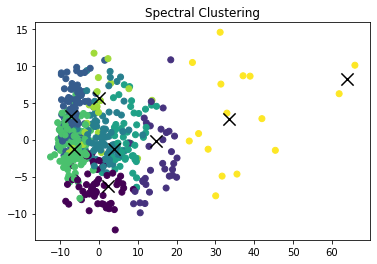

In [16]:
#visualize the results using PCA
labels = clustering.labels_
plt.scatter(X_trans_pca[:,0],X_trans_pca[:,1],c=labels)
plt.scatter(pca.transform(opt_centers)[:,0],pca.transform(opt_centers)[:,1],marker="x",s=150,c="black")
plt.title("Spectral Clustering")


### Compare k means with spectral clusering

* here I tried to count the number of items in each cluster and use this to compare k-mean and spectral clustering
* don't know yet if this is correct and if the cluster number is the same for k-mean and spectral clustering

In [17]:
#print first 20 labels for spectral clustering
clustering.labels_[:20]
sc = clustering.labels_

In [18]:
#print first 20 labels for k mean clustering
res['bicpars'][0].labels_[:20]
km=res['bicpars'][0].labels_

In [19]:
#get frequency in each cluster for k-mean clustering
unique, counts = np.unique(km, return_counts=True)

print(unique,counts)

ct_km = counts

[0 1 2 3 4 5 6 7] [ 49  99   2  13 143  45  90  42]


In [20]:
#get frequency in each cluster for spectral clustering
unique, counts = np.unique(sc, return_counts=True)

print(unique,counts)

ct_sc = counts

[0 1 2 3 4 5 6 7] [ 59  35  92  80  49 131  21  16]


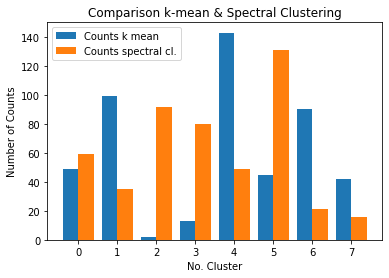

In [21]:
#plot frequency for k-mean and spectral clustering
clusters = ["0","1","2","3","4","5","6","7"]
  
X_axis = np.arange(len(ct_km))
  
plt.bar(X_axis - 0.2, ct_km, 0.4, label = "Counts k mean")
plt.bar(X_axis + 0.2, ct_sc, 0.4, label = "Counts spectral cl.")
  
plt.xticks(X_axis, clusters)
plt.xlabel("No. Cluster")
plt.ylabel("Number of Counts")
plt.title("Comparison k-mean & Spectral Clustering")
plt.legend()
plt.show()

### Silhoutte Analysis to find optimum number of Clusters

* trying to use silhoutte analysis to find the optimal number of cluster
* [silhoutte analysis](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)
* "Silhouette coefficients  near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster."
* The results (silhoutte score and looking at the graphs) suggest that 2 clusters are appropriate for this data-set. This in total contrast to k-mean clustering where 8 clusters are suggested.

For n_clusters = 2 The average silhouette_score is : 0.227
For n_clusters = 3 The average silhouette_score is : 0.129
For n_clusters = 4 The average silhouette_score is : 0.078
For n_clusters = 5 The average silhouette_score is : 0.078
For n_clusters = 6 The average silhouette_score is : 0.075
For n_clusters = 7 The average silhouette_score is : 0.053
For n_clusters = 8 The average silhouette_score is : 0.046
For n_clusters = 9 The average silhouette_score is : 0.042
For n_clusters = 10 The average silhouette_score is : 0.039


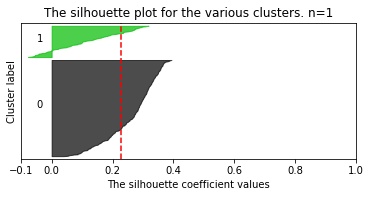

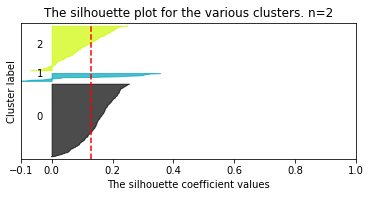

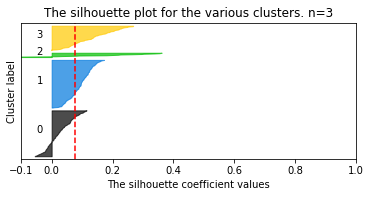

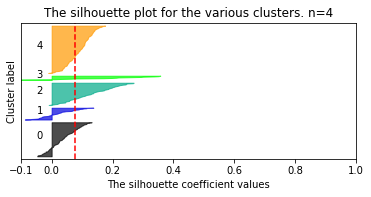

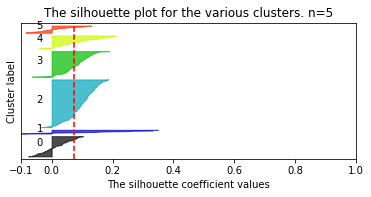

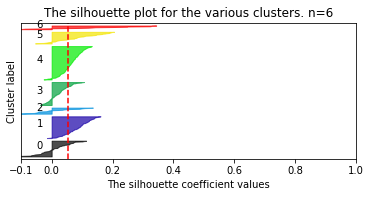

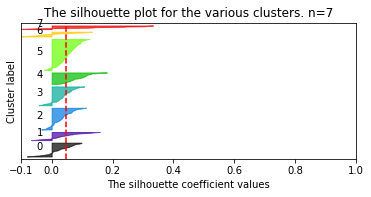

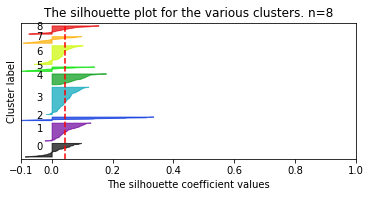

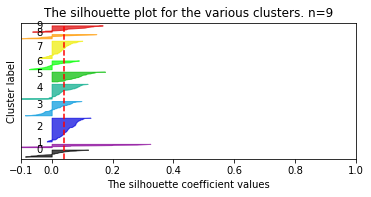

In [22]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

import warnings
warnings.filterwarnings('ignore')

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1) = plt.subplots(1)
    fig.set_size_inches(6, 2.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = SpectralClustering(n_clusters=n_clusters,
        assign_labels='discretize',
        affinity="nearest_neighbors",
        random_state=0)
    cluster_labels = clusterer.fit_predict(X)


    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        round(silhouette_avg,3),
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        ax1.set_title(f"The silhouette plot for the various clusters. n={i}")
        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()

### Consensus Clustering

* We tried consensus clustering based on this approach [ConsensusClustering](https://towardsdatascience.com/consensus-clustering-f5d25c98eaf2)
* further information can be found in this interesting [article](https://link.springer.com/content/pdf/10.1023/A:1023949509487.pdf)
* re-running the next cell will last app. 20-30min ;-)
* we also tried to run it with `n_splits=100` but the results are very similar
* there is also some code to run it for only one cluster number and a test case to show that the code actually works.
* the results suggests that 2-3 clusters are appropriate

REMARKS DAVID:
* what i cant figure out. In the tutorial and paper they wrote "We then compute a CDF for each consensus matrix from every K. For each step in K, we calculate the change in the area under the CDF and use the usual elbow method to choose K. With the plot on the left, we’d choose K=3." i calculated the area under the cdf but dont know if the change is correct
* so i don't know yet how to do this but the results from the plots (ECDF and histogram) can be also used
* i was also not able to plot the heatmaps like in figure2 from the article
* and the results look similar to silhoutte method -> 2-3 clusters are optimal

In [167]:
from sklearn.model_selection import KFold
import pandas as pd
from itertools import combinations

ct=0
n_clsters = range(2,11) #number of cluster
kf = KFold(n_splits=50, shuffle=True, random_state = ct) #number of KFold splitting for one cluster number
res={}

for n_clusters in n_clsters:
    ct=0
    d={}
    d_index={}
    d_res={}
    for train_index,test_index in kf.split(X):  
        clusterer = SpectralClustering(n_clusters=n_clusters, 
            assign_labels='discretize',
            affinity="nearest_neighbors", random_state=ct)
        cluster_labels = clusterer.fit_predict(X[train_index])
        d_index[ct]=train_index.tolist()
        d[ct]=cluster_labels.tolist()
        d_res[ct]= pd.DataFrame(d[ct], index = d_index[ct])
        ct += 1
    
    # concatenating the DataFrames
    df = pd.concat(d_res.values(), axis=1)
    # create all combinations of rows from the provided data.frame (list(combinations(test.index,2))
    # results in 2 rows which are stored in tmp
    # these 2 rows are then comared with tmp.diff
    # ct_2gether is the number of items which are the same in the 2 rows
    # ct_len number how often they occurred together during the simulation
    result_consensus = {}

    for index in list(combinations(df.index,2)):
        tmp = df.loc[index,:]
        tmp_diff = tmp.diff(periods=1,axis=0) #calculate difference between 2 rows
        ct_2gether = (tmp_diff == 0).astype(int).sum(axis=1).tolist()[1]#get sum of 0 values -> 0 means they are equal
        ct_len = len(df.columns)-tmp_diff.isnull().sum(axis=1).tolist()[1] #number of columns - number of NaN
        value = ct_2gether / ct_len
        result_consensus[index]=value

    res[n_clusters]=list(result_consensus.values())


* plot results 
    + histogram of value distribution of consensus matrix
    + ECDF of consensus matrix for every number of cluster

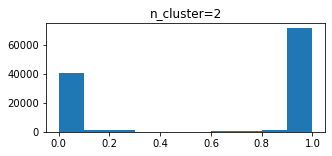

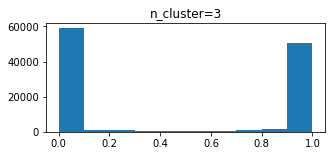

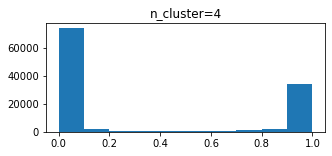

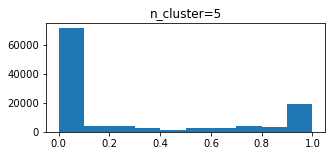

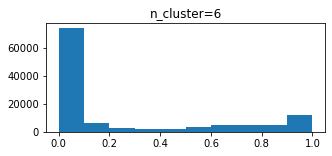

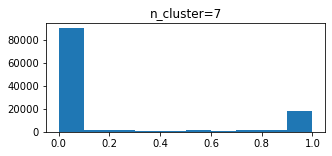

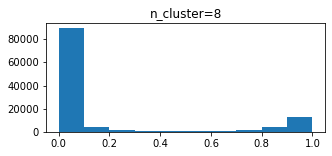

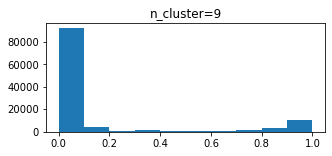

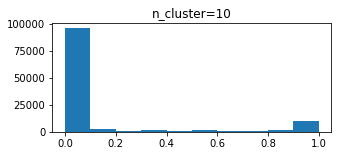

In [168]:
for n in res:
    fig, ax = plt.subplots(1,1, figsize=(5, 2))
    plt.hist(res[n], bins=10)
    plt.title(f"n_cluster={n}")
plt.show()
    

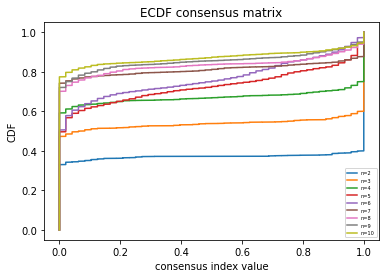

Area ecdf:[954.1229508196723, 701.222891566265, 653.9494382022473, 612.6473684210526, 612.6473684210526, 632.625, 632.625, 625.8225806451613, 632.625]


Text(0, 0.5, 'area ecdf')

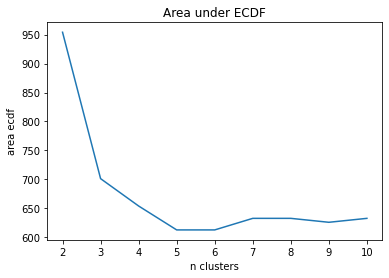

In [169]:
#ecdf
from statsmodels.distributions.empirical_distribution import ECDF
from numpy import trapz

area_ecdf=[]

for n in res:
    ecdf=ECDF(res[n])
    plt.plot(ecdf.x,ecdf.y, label = f"n={n}")
    #dx spacing between sample points when x is None. by default. It is 1.
    #so we used 1/(unique x values) to get this spacing
    #unique x values which are >0 and < 1: len(_tmp[np.logical_and(_tmp>0,_tmp<1)])
    _tmp = np.unique(ecdf.x)
    area_ecdf.append(trapz(y=ecdf.y, x=None, dx = 1/len(_tmp[np.logical_and(_tmp>0,_tmp<1)]))) 

plt.xlabel("consensus index value")
plt.ylabel("CDF")
plt.title("ECDF consensus matrix")
plt.legend(prop={"size":5})
plt.show()

print(f"Area ecdf:{area_ecdf}")
plt.plot(n_clsters,area_ecdf)
plt.title("Area under ECDF")
plt.xlabel("n clusters")
plt.ylabel("area ecdf")

#### Example ECDF

P(x<20): 0.124
P(x<40): 0.652
P(x<60): 1.000


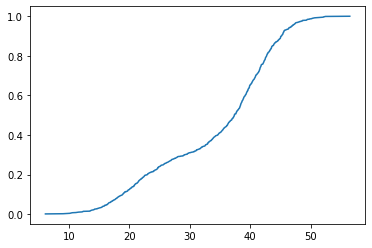

In [26]:
from statsmodels.distributions.empirical_distribution import ECDF
from matplotlib import pyplot
from numpy.random import normal
from numpy import hstack

sample1 = normal(loc=20, scale=5, size=300)
sample2 = normal(loc=40, scale=5, size=700)
sample = hstack((sample1, sample2))
ecdf = ECDF(sample)
# get cumulative probability for values
print('P(x<20): %.3f' % ecdf(20))
print('P(x<40): %.3f' % ecdf(40))
print('P(x<60): %.3f' % ecdf(60))
# plot the cdf
pyplot.plot(ecdf.x, ecdf.y)
pyplot.show()


In [27]:
def ecdf(data):
    """ Compute ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return(x,y)
    

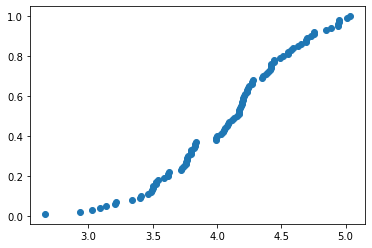

In [28]:
mu1, sigma1 = 4, 0.5
rand_normal1 = np.random.normal(mu1, sigma1, 100)
x,y = ecdf(rand_normal1)
plt.scatter(x=x, y=y)

### Consensus Cluster - code for one cluster

In [110]:
from sklearn.model_selection import KFold
import pandas as pd

n_clusters = 7 #number of cluster
d={}
d_index={}
d_res={}
kf = KFold(n_splits=10, shuffle=True, random_state = ct)
ct=0

for train_index,test_index in kf.split(X):  
    clusterer = SpectralClustering(n_clusters=n_clusters, 
        assign_labels='discretize',
        affinity="nearest_neighbors", random_state=ct)
    cluster_labels = clusterer.fit_predict(X[train_index])
    d_index[ct]=train_index.tolist()
    d[ct]=cluster_labels.tolist()
    #t0 = pd.DataFrame(d[0], index = d_index[0])
    d_res[ct]= pd.DataFrame(d[ct], index = d_index[ct])
    ct += 1

In [30]:
# concatenating the DataFrames
df = pd.concat(d_res.values(), axis=1)
df.head()

,0,0,0,0,0,0,0,0,0,0
0,1.0,0.0,1.0,0.0,0.0,NaN,0.0,1.0,1.0,0.0
1,0.0,NaN,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
2,1.0,0.0,1.0,0.0,NaN,0.0,0.0,1.0,1.0,0.0
3,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,NaN,0.0


In [31]:
test = df

In [32]:
# create all combinations of rows from the provided data.frame (list(combinations(test.index,2))
# results in 2 rows which are stored in tmp
# these 2 rows are then comared with tmp.diff
# ct_2gether is the number of items which are the same in the 2 rows
# ct_len number how often they occurred together during the simulation
from itertools import combinations

result_consensus = {}

for index in list(combinations(test.index,2)):
    tmp = test.loc[index,:]
    tmp_diff = tmp.diff(periods=1,axis=0)
    ct_2gether = (tmp_diff == 0).astype(int).sum(axis=1).tolist()[1]#get sum of 0 values -> 0 means they are equal
    ct_len = len(test.columns)-tmp_diff.isnull().sum(axis=1).tolist()[1] #number of columns - number of NaN
    value = ct_2gether / ct_len
    result_consensus[index]=value
    #print(index)
    #print("original")
    #print(tmp)
    #print(f"2gether: {ct_2gether} | len: {ct_len}   |  value:  {value}")
    #print("\n")

KeyboardInterrupt: 

(array([39291.,  1233.,  1416.,   866.,   121.,  1585.,  1296.,   896.,
         1340., 68359.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

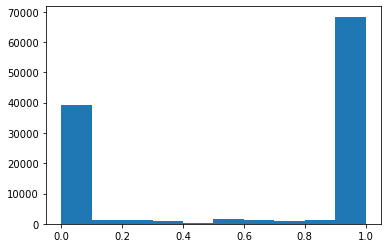

In [ ]:
res = list(result_consensus.values())
plt.hist(res, bins=10)

In [ ]:
import numpy as np
from scipy.integrate import simps
from numpy import trapz

# Compute the area using the composite trapezoidal rule.
area = trapz(res, dx=5)
print("area =", area)
# Compute the area using the composite Simpson's rule.
area = simps(res, dx=5)
print("area =", area)

area = 107200.06944444445
area = 107170.74074074073


#### additional if you want to get the whole consensus matrix

In [ ]:
# result = np.zeros((20,20)) #hard coded -> has to be adapted to dim of result_consensus
# np.fill_diagonal(result,1)
# result
# for key, val in result_consensus.items():
#     result[key[0]][key[1]] = val
# result


* get also lower triangle

In [ ]:
# result = result + result.T -np.diag(np.diag(result))

* example for getting lower triangle for upper triangle

In [ ]:
# import numpy as np

# X= np.array([[0., 2., 3.],
#              [0., 0., 6.],
#              [0., 0., 0.]])

# X = X + X.T - np.diag(np.diag(X))
# print(X)

# #array([[0., 2., 3.],
# #       [2., 0., 6.],
# #       [3., 6., 0.]])

#### TEST case from tutorial 
* https://towardsdatascience.com/consensus-clustering-f5d25c98eaf2
* original matrix

In [ ]:
tmp_dict={"A":[2,0,2,1],"B":[1,1,1,2],"C":[1,2,0,2],"D":[0,2,1,0]}
test = pd.DataFrame.from_dict(tmp_dict)
test = test.transpose()
test

,0,1,2,3
A,2,0,2,1
B,1,1,1,2
C,1,2,0,2
D,0,2,1,0


* had to change from 0 to NaN for samples which were not sub-sampled and re-name rows (index) from A-D to 0-4

In [ ]:
tmp_dict={0:[2,float("NaN"),2,1],1:[1,1,1,2],2:[1,2,float("NaN"),2],3:[float("NaN"),2,1,float("NaN")]}
test = pd.DataFrame.from_dict(tmp_dict)
test = test.transpose()
test

,0,1,2,3
0,2.0,NaN,2.0,1.0
1,1.0,1.0,1.0,2.0
2,1.0,2.0,NaN,2.0
3,NaN,2.0,1.0,NaN


In [ ]:
# create all combinations of rows from the provided data.frame (list(combinations(test.index,2))
# results in 2 rows which are stored in tmp
# these 2 rows are then comared with tmp.diff
# ct_2gether is the number of items which are the same in the 2 rows
# ct_len number how often they occured together during the simulation
from itertools import combinations

result_consensus = {}

for index in list(combinations(test.index,2)):
    tmp = test.loc[index,:]
    tmp_diff = tmp.diff(periods=1,axis=0)
    ct_2gether = (tmp_diff == 0).astype(int).sum(axis=1).tolist()[1]#get sum of 0 values -> 0 means they are equal
    ct_len = len(test.columns)-tmp_diff.isnull().sum(axis=1).tolist()[1] #number of columns - number of NaN
    value = ct_2gether / ct_len
    result_consensus[index]=value
    print(index)
    print("original")
    print(tmp)
    print(f"2gether: {ct_2gether} | len: {ct_len}   |  value:  {value}")
    print(f"diff: {tmp_diff}")
    print("\n")

(0, 1)
original
     0    1    2    3
0  2.0  NaN  2.0  1.0
1  1.0  1.0  1.0  2.0
2gether: 0 | len: 3   |  value:  0.0
diff:      0   1    2    3
0  NaN NaN  NaN  NaN
1 -1.0 NaN -1.0  1.0


(0, 2)
original
     0    1    2    3
0  2.0  NaN  2.0  1.0
2  1.0  2.0  NaN  2.0
2gether: 0 | len: 2   |  value:  0.0
diff:      0   1   2    3
0  NaN NaN NaN  NaN
2 -1.0 NaN NaN  1.0


(0, 3)
original
     0    1    2    3
0  2.0  NaN  2.0  1.0
3  NaN  2.0  1.0  NaN
2gether: 0 | len: 1   |  value:  0.0
diff:     0   1    2   3
0 NaN NaN  NaN NaN
3 NaN NaN -1.0 NaN


(1, 2)
original
     0    1    2    3
1  1.0  1.0  1.0  2.0
2  1.0  2.0  NaN  2.0
2gether: 2 | len: 3   |  value:  0.6666666666666666
diff:      0    1   2    3
1  NaN  NaN NaN  NaN
2  0.0  1.0 NaN  0.0


(1, 3)
original
     0    1    2    3
1  1.0  1.0  1.0  2.0
3  NaN  2.0  1.0  NaN
2gether: 1 | len: 2   |  value:  0.5
diff:     0    1    2   3
1 NaN  NaN  NaN NaN
3 NaN  1.0  0.0 NaN


(2, 3)
original
     0    1    2    3
2  1.0  2

In [ ]:
result_consensus

{(0, 1): 0.0,
 (0, 2): 0.0,
 (0, 3): 0.0,
 (1, 2): 0.6666666666666666,
 (1, 3): 0.5,
 (2, 3): 1.0}

In [ ]:
result = np.zeros((4,4)) #hard coded -> has to be adapted to dim of result_consensus
#np.fill_diagonal(result,1)
result
for key, val in result_consensus.items():
    result[key[0]][key[1]] = val
result

array([[0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.66666667, 0.5       ],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.        , 0.        ]])

In [ ]:
#with lower triangle
result = result + result.T -np.diag(np.diag(result))
np.fill_diagonal(result,1)
result

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.66666667, 0.5       ],
       [0.        , 0.66666667, 1.        , 1.        ],
       [0.        , 0.5       , 1.        , 1.        ]])

(array([3., 0., 0., 0., 0., 1., 1., 0., 0., 1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

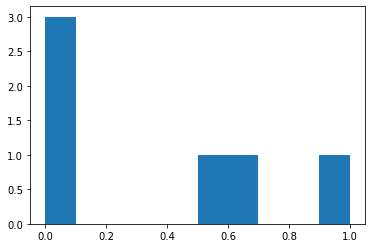

In [ ]:
res = list(result_consensus.values())
plt.hist(res, bins=10)

## Discussion
Provide a discussion of your findings. Compare the results obtauned with k-means and spectral clustering. Which visualisation provides better results PCA or tSNE? 